# Demo: Compare two registered images

This demo will walk you through running the image_comparison tool on some sample images

## Initialize the notebook environment

Edit the `BUILD_DIR` path to reflect your build directory. `"../build/Release/"` is the default for Xcode. If you are using cmake and you followed my setup instructions, your build directory is `"../build/"`

In [1]:
BUILD_DIR="../build/Release"
!echo $BUILD_DIR

../build/Release


In [2]:
!rm -r output/image_comparison_demo
!mkdir -p output/image_comparison_demo

# This sys call is needed because the file is in another directory 
import sys
sys.path.insert(1, '../scripts/python/landmark_tools')

import visualize_corr
import mask_by_intensity

## Dependencies

This demo assumes you have already followed the steps to [Install the tools](INSTALL.md).

You will need the following python libraries

- numpy
- opencv-python

Reload the jupyter kernel after installing these libraries.

We are going to use the demo images located in [../imgs](../imgs)

## image_comparison

### Test data

We are going to use the demo images

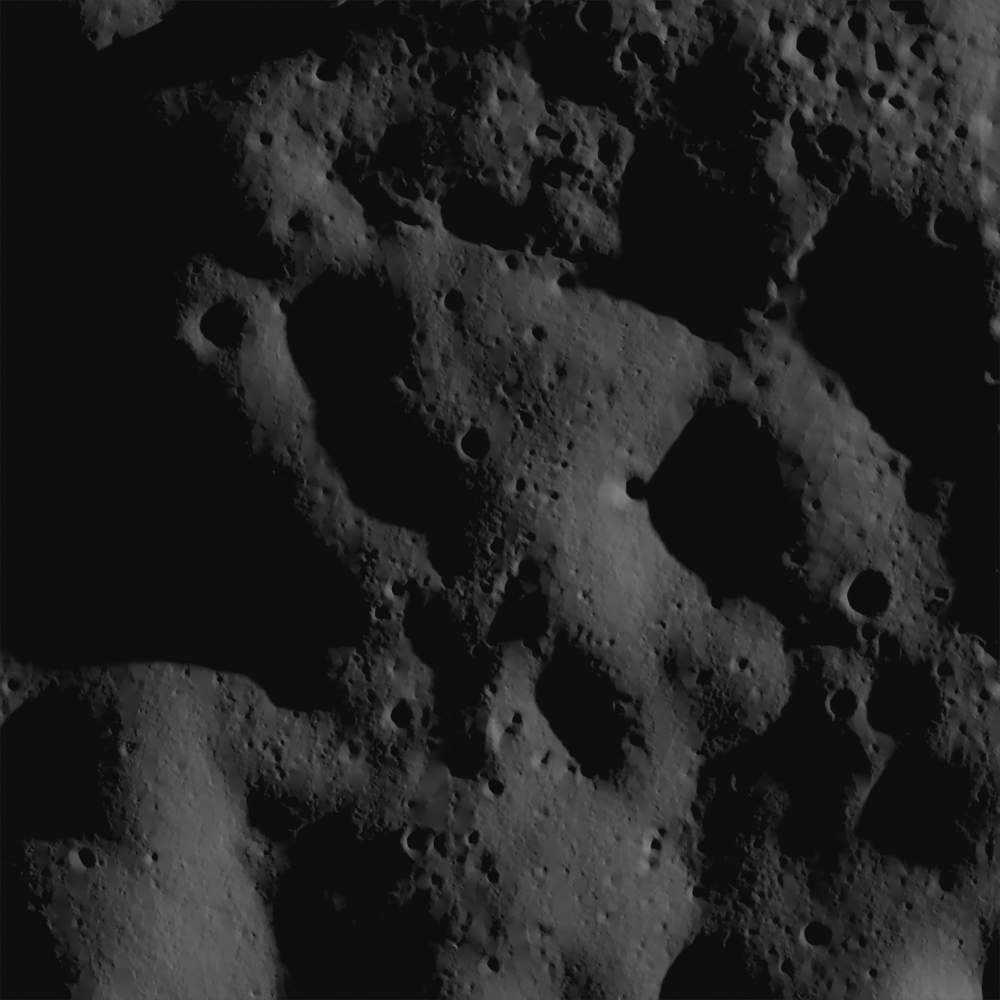

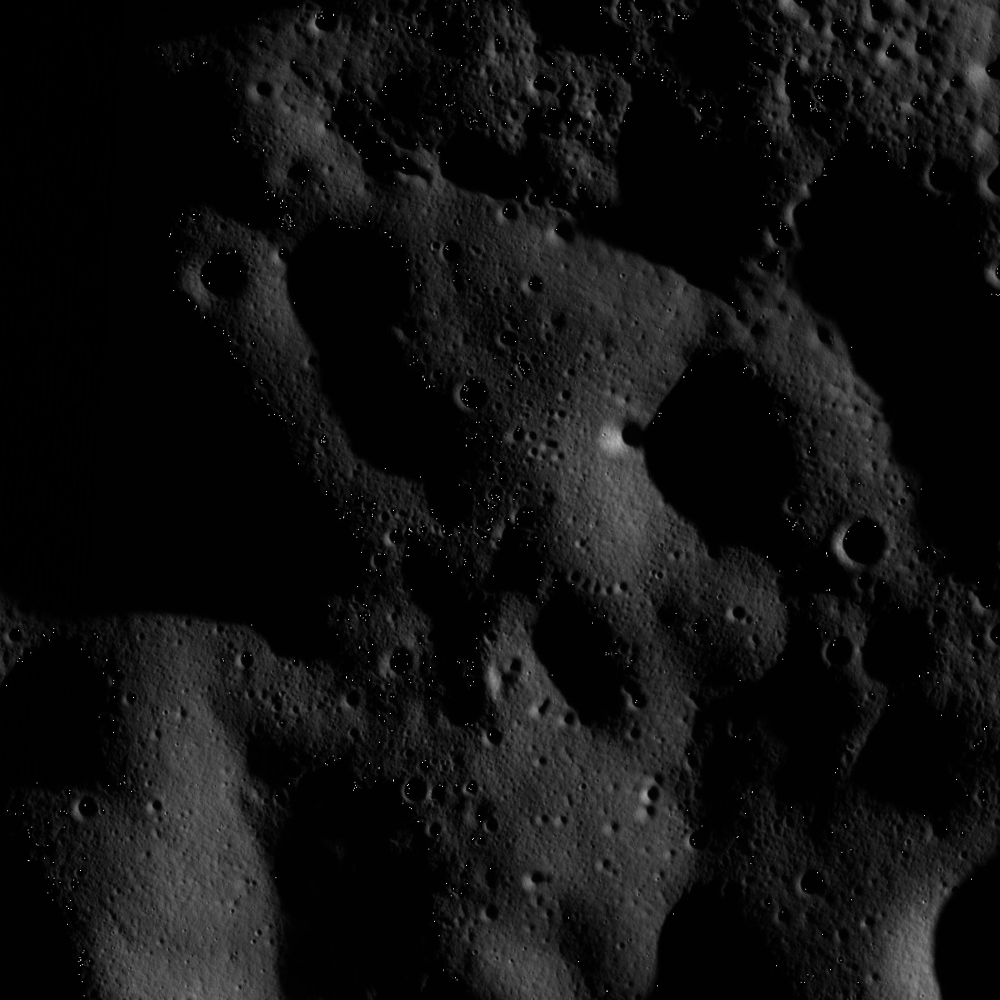

In [3]:
from IPython.display import Image, display
image_path_list = [
    "demo_image_comparison_hillshade.png",
    "demo_image_comparison_kaguya.png",
]
for image_path in image_path_list:
    display(Image(filename=image_path))

The test data is in png format.
image_comparison requires insensity images in pgm format, as well as corresponding nan masks where zero-pixels are to be included in the comparison and non-zero pixels are to be left out of the comparison.
We provide a tool to easily do this conversion and masking based on input intensity.
In the following example, we mask-out hillshade pixels of intensity 14 or less (--mask_out_intensity_less_than 15) and set these pixels to 255 in the mask image (--mask_out_value 255), and other pixels to 0 (--mask_in_value 0).
For Kaguya images, we mask out intensities 2 or less (--mask_out_intensity_less_than 3).

In [4]:
!python ../scripts/python/landmark_tools/mask_by_intensity.py \
  --input_image demo_image_comparison_hillshade.png \
  --output_intensity output/image_comparison_demo/hillshade_intensity.pgm \
  --output_mask output/image_comparison_demo/hillshade_mask.pgm \
  --mask_out_intensity_less_than 15 --mask_out_value 255 --mask_in_value 0

!python ../scripts/python/landmark_tools/mask_by_intensity.py \
  --input_image demo_image_comparison_kaguya.png \
  --output_intensity output/image_comparison_demo/kaguya_intensity.pgm \
  --output_mask output/image_comparison_demo/kaguya_mask.pgm \
  --mask_out_intensity_less_than 3 --mask_out_value 255 --mask_in_value 0

Load image: demo_image_comparison_hillshade.png
Write intensity: output/image_comparison_demo/hillshade_intensity.pgm
Mask out pixels less than 15
  Set masked-in pixels to --mask_in_value=0 and masked-out pixels to --mask_out_value=255
  Write mask: output/image_comparison_demo/hillshade_mask.pgm
Load image: demo_image_comparison_kaguya.png
Write intensity: output/image_comparison_demo/kaguya_intensity.pgm
Mask out pixels less than 3
  Set masked-in pixels to --mask_in_value=0 and masked-out pixels to --mask_out_value=255
  Write mask: output/image_comparison_demo/kaguya_mask.pgm


### Running the comparison tool

Now we're ready to compare images.
Part of the comparison pipeline consists in matching templates from one image to the other.

`-warp template` lets you reproject templates to the other frame individually while `-warp image` does it on the entire image then looks for matches in the vicinity of the same pixel. We found that `-warp image` generally provides better results.
`-base_nan_max_count` and `-child_nan_max_count` let you control how many NaNs are allowed in each template. Set to -1 to allow any number of NaNs, 0+ to allow up to this number of NaNs. Here, we set it to zero to allow none.

In [5]:
!$BUILD_DIR/image_comparison \
  -base_image output/image_comparison_demo/hillshade_intensity.pgm \
  -base_nan_mask output/image_comparison_demo/hillshade_mask.pgm \
  -base_nan_max_count 0 \
  -child_image output/image_comparison_demo/kaguya_intensity.pgm \
  -child_nan_mask output/image_comparison_demo/kaguya_mask.pgm \
  -child_nan_max_count 0 \
  -warp image \
  -output_dir output/image_comparison_demo \
  -output_filename_prefix comparison \
  -homography_max_dist_between_matching_keypoints 0 \
  -c custom_parameters.txt

Calculate homography with feature matching method SIFT
Found 213 inliers for homography match method SIFT
  New best!
Calculate homography with feature matching method ORB
Found 13 inliers for homography match method ORB
Calculate homography with feature matching method SIFT
Found 213 inliers for homography match method SIFT
Best homography: SIFT with 213 inliers
line = 0
num_matched_features 0
num_matched_features 0
num_matched_features 0
num_matched_features 0
num_matched_features 0
line = 200
num_matched_features 0
num_matched_features 0
num_matched_features 14
num_matched_features 251
i = 200 j = 600
best feat for homography 250
num_matched_features 0
line = 400
num_matched_features 0
num_matched_features 0
num_matched_features 69
i = 400 j = 400
best feat for homography 69
num_matched_features 87
i = 400 j = 600
best feat for homography 79
num_matched_features 13
line = 600
num_matched_features 154
i = 600 j = 0
best feat for homography 153
num_matched_features 119
i = 600 j = 200

Now we can use the python visualization tools (`scripts/visualize_corr.py`) to look at these results.

The `image_comparison` executable generates a vector field representing the displacement between the most highly correlated patches in the two images. Each dimension of the vector field is stored as an image. Let's start by looking at the x-dimension, stored as `<prefix>_delta_x_wbyh.raw`

/Users/cmauceri/Workspace/LanderVisionSystem/landmark_tools/example/../scripts/python/landmark_tools/visualize_corr.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


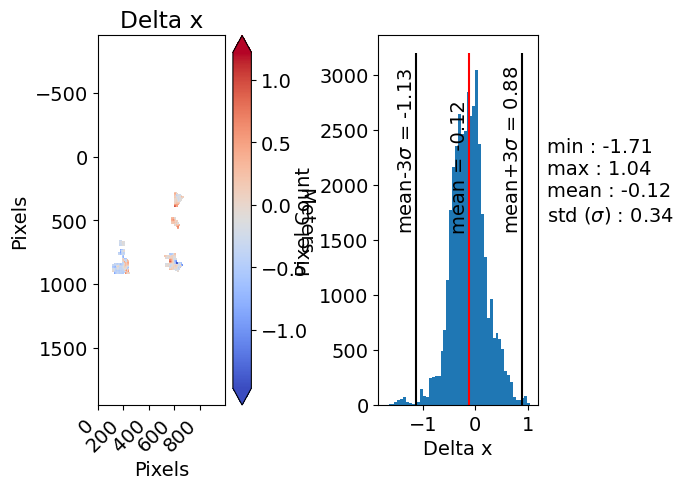

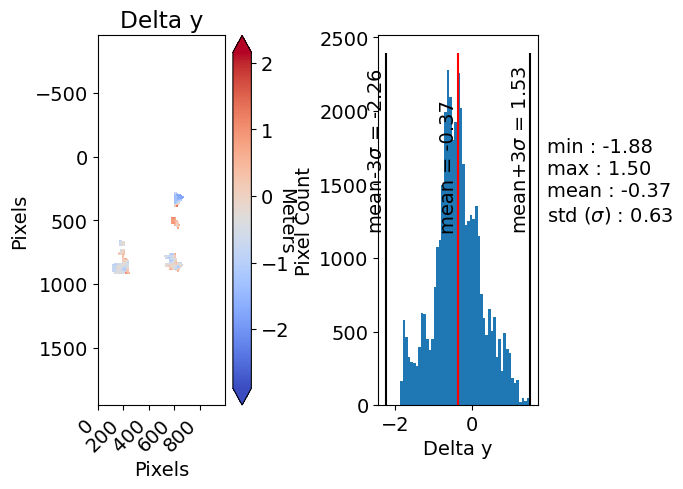

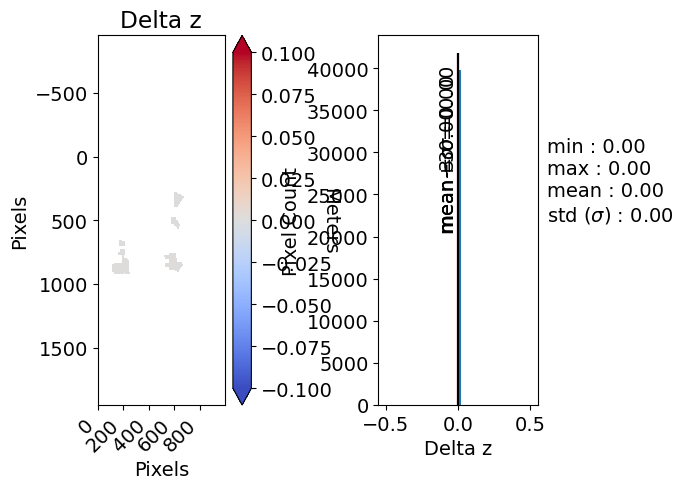

In [6]:
width = 1000
height = 1000
input_prefix = "output/image_comparison_demo/comparison"
output_prefix = "output/image_comparison_demo/plots"
visualize_corr.displayAll(
    input_prefix,
    width,
    height,
    output_prefix,
)